In [ ]:
!pip install transformers

In [ ]:
import torch
import pandas as pd
import transformers
from transformers import AutoTokenizer, AutoModel
from sklearn.metrics.pairwise import cosine_similarity

In [ ]:
sentences = [
             "Three years later, the coffin was still full of Jello.",
             "The fish dreamed of escaping the fishbowl and into the toilet where he saw his friend go.",
             "The person box was packed with jelly many dozens of months later.",
             "Standing on one's head at job interviews forms a lasting impression.",
             "It took him a month to finish the meal.",
             "Finishing the meal took him 3 weeks."
]

In [ ]:
model_name = 'sentence-transformers/bert-base-nli-mean-tokens'

tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)

tokenizer_config.json:   0%|          | 0.00/399 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

In [ ]:
def compute_tokens(sentences, tokenizer):

    input_ids = []
    attention_mask = []

    # encoding all sentences for bert input
    for sentence in sentences:
        sentence_encoding = tokenizer.encode_plus(
            sentence,
            max_length=128,
            truncation=True,
            padding='max_length',
            return_tensors='pt'
        )

        input_ids.append(sentence_encoding['input_ids'][0])
        attention_mask.append(sentence_encoding['attention_mask'][0])

    # stacking all the input_ids and attention_mask along 1 dim
    input_ids = torch.stack(input_ids)
    attention_mask = torch.stack(attention_mask)
    # final shape of input_ids & attention_mask = torch.Size([6, 128]), initially they were list.

    return {
        'input_ids': input_ids,
        'attention_mask': attention_mask
    }

In [ ]:
def compute_sentence_vector(tokens, model):

    last_hidden_state, pooled_output = model(**tokens, return_dict=False)
    '''
    Now let's apply mean pooling on last_hidden_state vector of shape torch.Size([6,128,768])
    to convert it into meaningful sentence embedding.

    For this we need to create a sentence vector by multiplying the attention_mask
    with last_hidden_state so that we ignore non-real tokens i.e. ignore padding tokens.

    The final sentence vector will have 768 embeddings for those
    words where there was 1 else 0 = padding tokens.
    In order to multiply, we need to expand attention_mask dim by 1 so that both becomes [6,128,768].
    '''
    attention_mask = tokens['attention_mask'].unsqueeze(-1).expand(last_hidden_state.shape).float()
    masked_embeddings = last_hidden_state * attention_mask

    # applying mean pooling
    '''
    This pooling operation will take the mean of all token embeddings and compress them into a
    single 768 vector space — creating a ‘sentence vector’.

    At the same time, we can’t just take the mean activation as is. We need to consider
    null padding tokens (which we should not include).
    '''
    summed = torch.sum(masked_embeddings, dim=1) # shape = [6,768]
    counts = torch.clamp(attention_mask.sum(dim=1), min=1e-9) # shape = [6,768]
    mean_pooled_embedding = summed / counts # shape = [6, 768] i.e. our final sentence vector.

    return mean_pooled_embedding

In [ ]:
def compute_similarity(sentences, tokenizer, model):

    sentences_tokens = compute_tokens(sentences, tokenizer)
    sentences_embeddings = compute_sentence_vector(sentences_tokens, model)
    sentences_embeddings_detached = sentences_embeddings.detach().numpy()
    similarity_scores = cosine_similarity([sentences_embeddings_detached[0]], sentences_embeddings_detached[1:])

    d = {
        'column-1': [sentences[0] for _ in range(len(sentences)-1)],
        'column-2': [sent for sent in sentences[1:]],
        'scores': similarity_scores[0]
    }

    output = pd.DataFrame(data=d)

    return output

In [ ]:
output = compute_similarity(sentences, tokenizer, model)

In [ ]:
output

,column-1,column-2,scores
0,"Three years later, the coffin was still full o...",The fish dreamed of escaping the fishbowl and ...,0.330889
1,"Three years later, the coffin was still full o...",The person box was packed with jelly many doze...,0.721926
2,"Three years later, the coffin was still full o...",Standing on one's head at job interviews forms...,0.174755
3,"Three years later, the coffin was still full o...",It took him a month to finish the meal.,0.447097
4,"Three years later, the coffin was still full o...",Finishing the meal took him 3 weeks.,0.579585


from matplotlib import pyplot as plt
output['scores'].plot(kind='hist', bins=20, title='scores')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
output.groupby('column-2').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
output['scores'].plot(kind='line', figsize=(8, 4), title='scores')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(output['column-2'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(output, x='scores', y='column-2', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

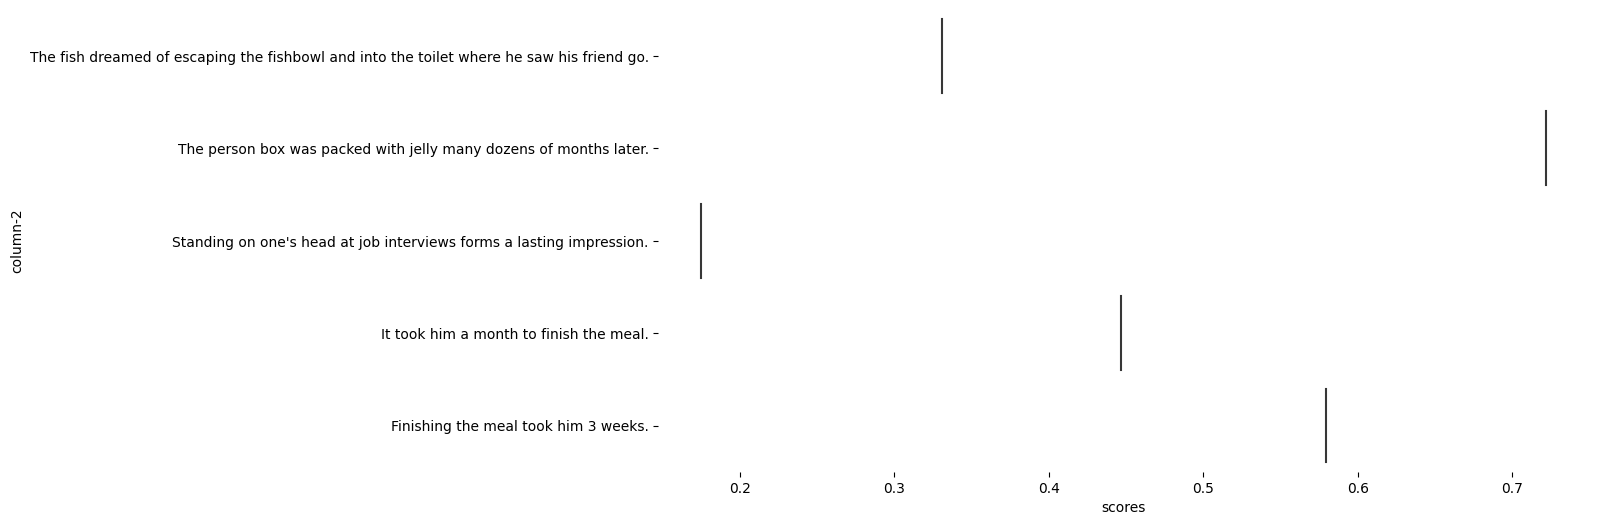

In [ ]:
from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(output['column-2'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(output, x='scores', y='column-2', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

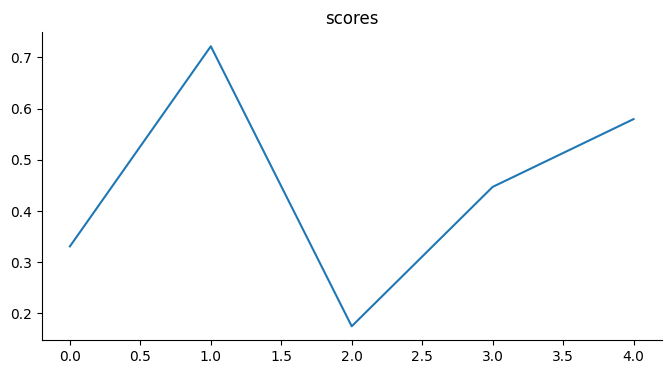

In [ ]:
from matplotlib import pyplot as plt
output['scores'].plot(kind='line', figsize=(8, 4), title='scores')
plt.gca().spines[['top', 'right']].set_visible(False)

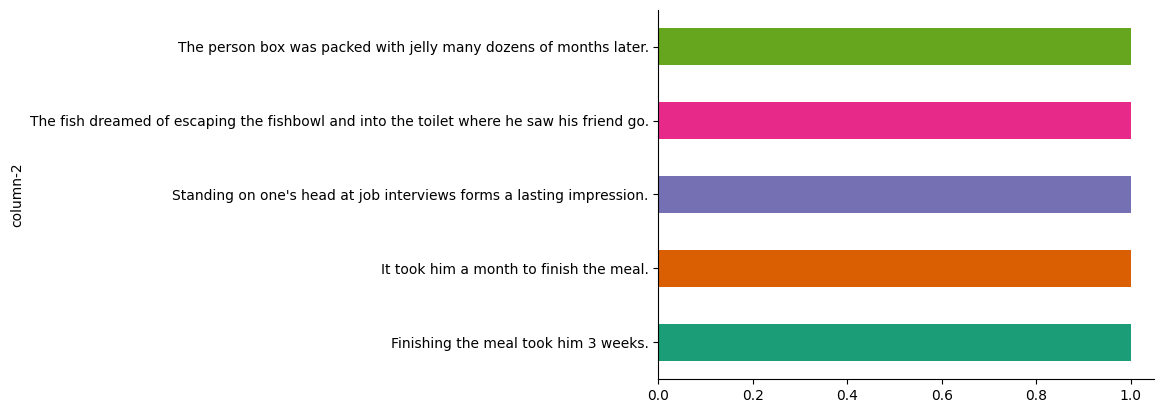

In [ ]:
from matplotlib import pyplot as plt
import seaborn as sns
output.groupby('column-2').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

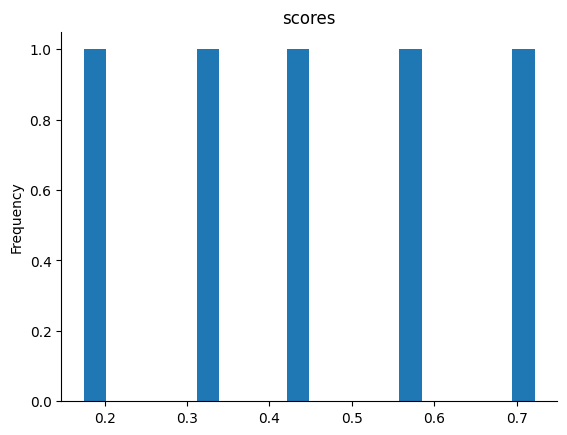

In [ ]:
from matplotlib import pyplot as plt
output['scores'].plot(kind='hist', bins=20, title='scores')
plt.gca().spines[['top', 'right',]].set_visible(False)